In [ ]:
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import numpy as np
import torch
import sys
import copy
import random
import numpy as np
from collections import defaultdict
from multiprocessing import Process, Queue
import json
import os
import time
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = 'drive/My Drive/puc/rec/project/data'
data_file = 'playlistid_itemid_1000p.txt'
tracks_names_file = f'{data_dir}/idx2name.json'

In [ ]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [ ]:
idx2name = read_json_file(tracks_names_file)

In [ ]:
from tqdm import tqdm

In [ ]:
track_names = list(idx2name.values())

In [ ]:
print(len(track_names))

34443


In [ ]:
print(track_names[:5])

['Yonkers', 'Lift Your Head Weary Sinner (Chains)', 'Paradise', 'Nightmare Seeker (The Little Red House)', 'American Country Love Song']


In [ ]:
class PointWiseFeedForward(torch.nn.Module):
    def __init__(self, hidden_units, dropout_rate):

        super(PointWiseFeedForward, self).__init__()

        self.conv1 = torch.nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = torch.nn.Dropout(p=dropout_rate)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = torch.nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs

# pls use the following self-made multihead attention layer
# in case your pytorch version is below 1.16 or for other reasons
# https://github.com/pmixer/TiSASRec.pytorch/blob/master/model.py

class SASRec(torch.nn.Module):
    def __init__(self, user_num, item_num, args, attention_hidden_units, tracks_embedding_matrix):
        super(SASRec, self).__init__()

        self.user_num = user_num
        self.item_num = item_num
        self.dev = args.device

        # TODO: loss += args.l2_emb for regularizing embedding vectors during training
        # https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
        self.item_emb = torch.nn.Embedding(self.item_num+1, args.hidden_units, padding_idx=0)
        self.pos_emb = torch.nn.Embedding(args.maxlen+1, args.hidden_units, padding_idx=0)
        self.emb_dropout = torch.nn.Dropout(p=args.dropout_rate)

        # ====================== CONTENT BASED ====================================
        # Content embedding layer (for precomputed embeddings)
        self.content_emb = torch.nn.Embedding(self.item_num+1, 768, padding_idx=0)

        # To match dim
        updated_embedding_matrix = torch.tensor(tracks_embedding_matrix).to(self.dev)
        zero_row = torch.zeros((1,768)).to(self.dev)
        updated_embedding_matrix = torch.cat((updated_embedding_matrix, zero_row), dim=0)

        # Fill content_emb with BERT embeddings
        self.content_emb.weight.data.copy_(updated_embedding_matrix.to(self.dev))
        self.content_emb.weight.requires_grad = False  # Freeze if you don't want them updated
        # ====================== END OF CONTENT BASED ====================================

        print(f'Content emb size:{self.content_emb}')
        print(f'Content emb size:{self.item_emb}')

        self.attention_layernorms = torch.nn.ModuleList() # to be Q for self-attention
        self.attention_layers = torch.nn.ModuleList()
        self.forward_layernorms = torch.nn.ModuleList()
        self.forward_layers = torch.nn.ModuleList()

        self.last_layernorm = torch.nn.LayerNorm(attention_hidden_units, eps=1e-8)

        for _ in range(args.num_blocks):
            new_attn_layernorm = torch.nn.LayerNorm(attention_hidden_units, eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)

            new_attn_layer =  torch.nn.MultiheadAttention(attention_hidden_units,
                                                            args.num_heads,
                                                            args.dropout_rate)
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = torch.nn.LayerNorm(attention_hidden_units, eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(attention_hidden_units, args.dropout_rate)
            self.forward_layers.append(new_fwd_layer)

            # self.pos_sigmoid = torch.nn.Sigmoid()
            # self.neg_sigmoid = torch.nn.Sigmoid()

    def log2feats(self, log_seqs): # TODO: fp64 and int64 as default in python, trim?
        seqs = self.item_emb(torch.LongTensor(log_seqs).to(self.dev))
        seqs *= self.item_emb.embedding_dim ** 0.5
        poss = np.tile(np.arange(1, log_seqs.shape[1] + 1), [log_seqs.shape[0], 1])
        # TODO: directly do tensor = torch.arange(1, xxx, device='cuda') to save extra overheads
        poss *= (log_seqs != 0)
        seqs += self.pos_emb(torch.LongTensor(poss).to(self.dev))

        seqs = self.emb_dropout(seqs)

        # Content embedding lookup
        item_content_embs = self.content_emb(torch.LongTensor(log_seqs).to(self.dev))
        # Concatenate the item embedding with the content embedding
        seqs = torch.cat([seqs, item_content_embs], dim=-1)

        tl = seqs.shape[1] # time dim len for enforce causality
        attention_mask = ~torch.tril(torch.ones((tl, tl), dtype=torch.bool, device=self.dev))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](Q, seqs, seqs,
                                            attn_mask=attention_mask)
                                            # need_weights=False) this arg do not work?
            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)

        log_feats = self.last_layernorm(seqs) # (U, T, C) -> (U, -1, C)

        return log_feats

    def forward(self, user_ids, log_seqs, pos_seqs, neg_seqs): # for training
        log_feats = self.log2feats(log_seqs) # user_ids hasn't been used yet

        pos_embs = self.item_emb(torch.LongTensor(pos_seqs).to(self.dev))
        neg_embs = self.item_emb(torch.LongTensor(neg_seqs).to(self.dev))

         # Content embedding lookup
        pos_item_content_embs = self.content_emb(torch.LongTensor(pos_seqs).to(self.dev))
        neg_item_content_embs = self.content_emb(torch.LongTensor(neg_seqs).to(self.dev))
        # Concatenate the item embedding with the content embedding
        # print('Concatenating')
        pos_embs = torch.cat([pos_embs, pos_item_content_embs], dim=-1)
        neg_embs = torch.cat([neg_embs, neg_item_content_embs], dim=-1)
        # print('Concatenated')

        pos_logits = (log_feats * pos_embs).sum(dim=-1)
        neg_logits = (log_feats * neg_embs).sum(dim=-1)

        # pos_pred = self.pos_sigmoid(pos_logits)
        # neg_pred = self.neg_sigmoid(neg_logits)

        return pos_logits, neg_logits # pos_pred, neg_pred

    def predict(self, user_ids, log_seqs, item_indices): # for inference
        log_feats = self.log2feats(log_seqs) # user_ids hasn't been used yet

        final_feat = log_feats[:, -1, :] # only use last QKV classifier, a waste

        item_embs = self.item_emb(torch.LongTensor(item_indices).to(self.dev)) # (U, I, C)

        # Content embedding lookup
        item_content_embs = self.content_emb(torch.LongTensor(item_indices).to(self.dev))
        # print(f'predict item_content_embs: {item_content_embs.shape}')
        # Concatenate the item embedding with the content embedding
        item_embs = torch.cat([item_embs, item_content_embs], dim=-1)

        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)

        # preds = self.pos_sigmoid(logits) # rank same item list for different users

        return logits # preds # (U, I)

In [ ]:
def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

data_dir = 'drive/My Drive/puc/rec/project/data'
data_file = 'playlistid_itemid_1000p_train.txt'

def build_index(n_users=999, n_items=34443):

    ui_mat = np.loadtxt(f'{data_dir}/{data_file}', dtype=np.int32)

    n_users = ui_mat[:, 0].max()
    n_items = ui_mat[:, 1].max()

    u2i_index = [[] for _ in range(n_users + 1)]
    i2u_index = [[] for _ in range(n_items + 1)]

    for ui_pair in ui_mat:
        u2i_index[ui_pair[0]].append(ui_pair[1])
        i2u_index[ui_pair[1]].append(ui_pair[0])

    return u2i_index, i2u_index

# sampler for batch generation
def random_neq(l, r, s):
    t = np.random.randint(l, r)
    while t in s:
        t = np.random.randint(l, r)
    return t


def sample_function(user_train, usernum, itemnum, batch_size, maxlen, result_queue, SEED):
    def sample(uid):

        # uid = np.random.randint(1, usernum + 1)
        user_train_keys = list(user_train.keys())
        while (uid not in user_train) or (len(user_train[uid]) <= 1):
          uid = np.random.randint(1, usernum + 1)

        seq = np.zeros([maxlen], dtype=np.int32)
        pos = np.zeros([maxlen], dtype=np.int32)
        neg = np.zeros([maxlen], dtype=np.int32)
        nxt = user_train[uid][-1]
        idx = maxlen - 1

        ts = set(user_train[uid])
        for i in reversed(user_train[uid][:-1]):
            seq[idx] = i
            pos[idx] = nxt
            if nxt != 0: neg[idx] = random_neq(1, itemnum + 1, ts)
            nxt = i
            idx -= 1
            if idx == -1: break

        return (uid, seq, pos, neg)

    np.random.seed(SEED)

    # user_train_uids = np.array(list(user_train.keys()))

    uids = np.arange(1, usernum+1, dtype=np.int32)
    # uids = uids[np.isin(uids, user_train_uids)]
    counter = 0
    while True:
        if counter % usernum == 0:
            np.random.shuffle(uids)
        one_batch = []
        for i in range(batch_size):
            one_batch.append(sample(uids[counter % usernum]))
            counter += 1
        result_queue.put(zip(*one_batch))


class WarpSampler(object):
    def __init__(self, User, usernum, itemnum, batch_size=64, maxlen=10, n_workers=1):
        self.result_queue = Queue(maxsize=n_workers * 10)
        self.processors = []
        for i in range(n_workers):
            self.processors.append(
                Process(target=sample_function, args=(User,
                                                      usernum,
                                                      itemnum,
                                                      batch_size,
                                                      maxlen,
                                                      self.result_queue,
                                                      np.random.randint(2e9)
                                                      )))
            self.processors[-1].daemon = True
            self.processors[-1].start()

    def next_batch(self):
        return self.result_queue.get()

    def close(self):
        for p in self.processors:
            p.terminate()
            p.join()


data_file = 'playlistid_itemid_1000p_train.txt'
# train/val/test data generation
def data_partition():
    usernum = 0
    itemnum = 0
    User = defaultdict(list)
    user_train = {}
    user_valid = {}
    user_test = {}
    # assume user/item index starting from 1
    f = open(f'{data_dir}/{data_file}', 'r')
    for line in f:
        u, i = line.rstrip().split(' ')
        u = int(u)
        i = int(i)
        # usernum = max(u, usernum)
        # itemnum = max(i, itemnum)
        User[u].append(i)

    for user in User:
        nfeedback = len(User[user])
        user_train[user] = User[user][:-1]
        user_valid[user] = []
        user_valid[user].append(User[user][-1])
    return [user_train, user_valid]

# TODO: merge evaluate functions for test and val set
# evaluate on test set
def evaluate(model, dataset, args):
    [train, valid, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    HT = 0.0
    valid_user = 0.0

    if usernum>10000:
        users = random.sample(range(1, usernum + 1), 10000)
    else:
        users = range(1, usernum + 1)
    for u in users:

        if len(train[u]) < 1 or len(test[u]) < 1: continue

        seq = np.zeros([args.maxlen], dtype=np.int32)
        idx = args.maxlen - 1
        seq[idx] = valid[u][0]
        idx -= 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break
        rated = set(train[u])
        rated.add(0)
        item_idx = [test[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        predictions = -model.predict(*[np.array(l) for l in [[u], [seq], item_idx]])
        predictions = predictions[0] # - for 1st argsort DESC

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user


# evaluate on val set
def evaluate_valid(model, dataset, args):
    [train, valid, usernum, itemnum] = copy.deepcopy(dataset)

    NDCG = 0.0
    valid_user = 0.0
    HT = 0.0
    users= train.keys()
    # if usernum>10000:
    #     users = random.sample(range(1, usernum + 1), 10000)
    # else:
    #     users = range(1, usernum + 1)
    for u in users:
        if len(train[u]) < 1 or len(valid[u]) < 1: continue

        seq = np.zeros([args.maxlen], dtype=np.int32)
        idx = args.maxlen - 1
        for i in reversed(train[u]):
            seq[idx] = i
            idx -= 1
            if idx == -1: break
        rated = set(train[u])
        rated.add(0)
        item_idx = [valid[u][0]]
        for _ in range(100):
            t = np.random.randint(1, itemnum + 1)
            while t in rated: t = np.random.randint(1, itemnum + 1)
            item_idx.append(t)

        predictions = -model.predict(*[np.array(l) for l in [[u], [seq], item_idx]])
        predictions = predictions[0]

        rank = predictions.argsort().argsort()[0].item()

        valid_user += 1

        if rank < 10:
            NDCG += 1 / np.log2(rank + 2)
            HT += 1
        if valid_user % 100 == 0:
            print('.', end="")
            sys.stdout.flush()

    return NDCG / valid_user, HT / valid_user

In [ ]:
def str2bool(s):
    if s not in {'false', 'true'}:
        raise ValueError('Not a valid boolean string')
    return s == 'true'

In [ ]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)

args = Args(
    batch_size=256,
    hidden_units=50,
    maxlen=200,
    num_blocks=2,
    num_heads=1,
    device='cuda',
    state_dict_path=None,
    inference_only=False,
    l2_emb=0.0,
    dropout_rate=0.2,
    num_epochs=100,
    lr=0.001,
    train_dir='drive/My Drive/puc/rec/project/models',
    dataset='playlistid_itemid_1000p_train'
)

In [ ]:
u2i_index, i2u_index = build_index()

# global dataset
dataset = data_partition()

usernum = 999
itemnum = 34443

[user_train, user_valid ] = dataset
user_train_keys = list(user_train.keys())
dataset.append(usernum)
dataset.append(itemnum)
print(len(user_train))
# [user_train, user_valid, user_test, usernum, itemnum] = dataset

num_batch = (len(user_train) - 1) // args.batch_size + 1
cc = 0.0

for u in user_train:
    cc += len(user_train[u])
print('average sequence length: %.2f' % (cc / len(user_train)))



sampler = WarpSampler(user_train, usernum, itemnum, batch_size=args.batch_size, maxlen=args.maxlen, n_workers=3)
print(f'Usernum: {usernum}')
print(f'Itemnum: {itemnum}')
print(list(user_train.keys()))

800
average sequence length: 62.61
Usernum: 999
Itemnum: 34443
[0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15, 17, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 119, 121, 122, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 200, 201, 202, 204, 206, 207, 209, 210, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 250, 251, 252, 253, 25

In [ ]:
track_embeding_matrix_file = f"{data_dir}/track_names_embedding_matrix.pt"
tracks_embedding_matrix = torch.load(track_embeding_matrix_file)
tracks_embedding_matrix.shape

<ipython-input-54-c8ede669411e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tracks_embedding_matrix = torch.load(track_embeding_matrix_file)


(34443, 768)

In [ ]:

model = SASRec(usernum, itemnum, args, 818, tracks_embedding_matrix).to(args.device) # no ReLU activation in original SASRec implementation?


for name, param in model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers

model.pos_emb.weight.data[0, :] = 0
model.item_emb.weight.data[0, :] = 0


model.train() # enable model training

epoch_start_idx = 1
if args.state_dict_path is not None:
    try:
        model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
        tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
        epoch_start_idx = int(tail[:tail.find('.')]) + 1
    except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
        print('failed loading state_dicts, pls check file path: ', end="")
        print(args.state_dict_path)
        print('pdb enabled for your quick check, pls type exit() if you do not need it')
        import pdb; pdb.set_trace()


if args.inference_only:
    model.eval()
    t_test = evaluate(model, dataset, args)
    print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

# ce_criterion = torch.nn.CrossEntropyLoss()
# https://github.com/NVIDIA/pix2pixHD/issues/9 how could an old bug appear again...
bce_criterion = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.98))

best_val_ndcg, best_val_hr = 0.0, 0.0
best_test_ndcg, best_test_hr = 0.0, 0.0
T = 0.0
t0 = time.time()

train_losses = []
ndcgs_valid = []
ndcgs_test = []
hr_valid = []
hr_test = []

for epoch in range(epoch_start_idx, args.num_epochs + 1):
    if args.inference_only: break # just to decrease identition
    for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
        u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
        # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
        adam_optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        for param in model.item_emb.parameters(): loss += args.l2_emb * torch.norm(param)
        loss.backward()
        adam_optimizer.step()
        print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs
        train_losses.append(loss.item())

    if epoch % 10 == 0:
        model.eval()
        t1 = time.time() - t0
        T += t1
        print('Evaluating', end='')
        t_valid = evaluate_valid(model, dataset, args)
        # print(t_valid)
        print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f)'
                % (epoch, T, t_valid[0], t_valid[1]))
        ndcgs_valid.append(t_valid[0])
        hr_valid.append(t_valid[1])

        if t_valid[0] > best_val_ndcg or t_valid[1] > best_val_hr:
            best_val_ndcg = max(t_valid[0], best_val_ndcg)
            best_val_hr = max(t_valid[1], best_val_hr)
            # folder = args.dataset + '_' + args.train_dir
            # fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
            # fname = fname.format(epoch, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
            # torch.save(model.state_dict(), os.path.join(folder, fname))

        # f.write(str(epoch) + ' ' + str(t_valid) + ' ' + str(t_test) + '\n')
        # f.flush()
        t0 = time.time()
        model.train()

    # if epoch == args.num_epochs:
    #     folder = args.dataset + '_' + args.train_dir
    #     fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
    #     fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
    #     torch.save(model.state_dict(), os.path.join(folder, fname))

# f.close()
sampler.close()
print("Done")

Content emb size:Embedding(34444, 768, padding_idx=0)
Content emb size:Embedding(34444, 50, padding_idx=0)
loss in epoch 1 iteration 0: 1.3974378108978271
loss in epoch 1 iteration 1: 1.3864238262176514
loss in epoch 1 iteration 2: 1.3735926151275635
loss in epoch 1 iteration 3: 1.3688760995864868
loss in epoch 2 iteration 0: 1.3561720848083496
loss in epoch 2 iteration 1: 1.3411657810211182
loss in epoch 2 iteration 2: 1.3296654224395752
loss in epoch 2 iteration 3: 1.2935360670089722
loss in epoch 3 iteration 0: 1.2815769910812378
loss in epoch 3 iteration 1: 1.2719287872314453
loss in epoch 3 iteration 2: 1.244018316268921
loss in epoch 3 iteration 3: 1.2011804580688477
loss in epoch 4 iteration 0: 1.1603457927703857
loss in epoch 4 iteration 1: 1.162309169769287
loss in epoch 4 iteration 2: 1.1419886350631714
loss in epoch 4 iteration 3: 1.1217674016952515
loss in epoch 5 iteration 0: 1.11075758934021
loss in epoch 5 iteration 1: 1.0893173217773438
loss in epoch 5 iteration 2: 1.06

In [ ]:
import matplotlib.pyplot as plt

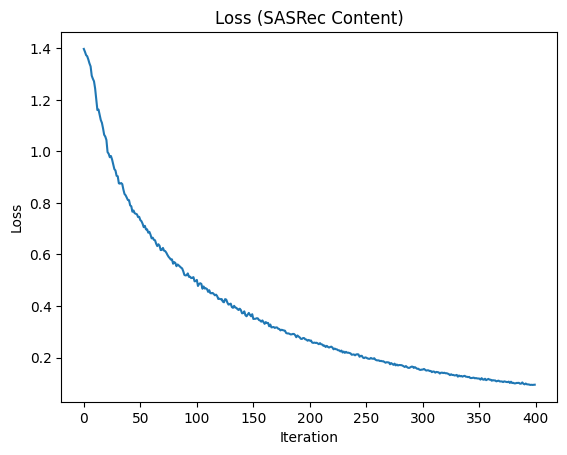

In [ ]:
plt.plot(train_losses)
plt.title('Loss (SASRec Content)')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [ ]:
print(f'HR {max(hr_valid)}')
print(f'NDCG@10 {max(ndcgs_valid)}')

HR 0.3225
NDCG@10 0.21581706892192265


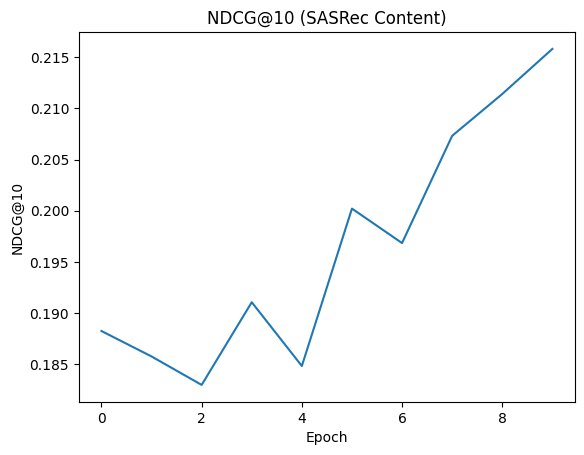

In [ ]:
plt.plot(ndcgs_valid)
plt.title('NDCG@10 (SASRec Content)')
plt.ylabel('NDCG@10')
plt.xlabel('Epoch')
plt.show()

In [ ]:
def read_interactions(file):
  ui_mat = np.loadtxt(f'{file}', dtype=np.int32)
  return ui_mat

In [ ]:
test_challenge_file_path = '/content/drive/My Drive/puc/rec/project/data/test_challenge_200p.txt'
test_challenge_dataset = read_interactions(test_challenge_file_path)

In [ ]:
import math

In [ ]:
idx2uri = read_json_file(f'{data_dir}/idx2uri.json')
genres = read_json_file(f'{data_dir}/uri2genres.json')

In [ ]:
def dcg(recommended_items, rel_items_labels):
  dcg_value = 0
  for idx, rel in enumerate(rel_items_labels):
    i = idx + 1
    dcg_value += ((2**rel-1)/math.log2(i + 1))
  return dcg_value

def ndcg(recommended_items, relevant_items):
  rel_items_labels = np.isin(recommended_items, relevant_items)
  count_rel_items = np.sum(rel_items_labels)
  ideal_rel_items_labels = np.concatenate([np.ones(count_rel_items, dtype=int), np.zeros(len(rel_items_labels) - count_rel_items, dtype=int)])
  dcg_value = dcg(recommended_items, rel_items_labels)
  ideal_dcg_value = dcg(recommended_items, ideal_rel_items_labels)
  ndcg_value = 0
  if dcg_value != 0:
    ndcg_value = dcg_value / ideal_dcg_value
  return ndcg_value

In [ ]:
def id2genre(idx):
  uri = idx2uri[str(idx)]
  if uri in genres:
    return genres[uri]
  else:
    return 'None'

In [ ]:
def recall_at_k(relevant_items, recommended_items, k):
    relevant_items = set(relevant_items)
    recommended_items = set(recommended_items[:k])
    intersection = relevant_items.intersection(recommended_items)
    recall = len(intersection) / len(relevant_items)
    return recall

def precision_at_k(relevant_items, recommended_items, k):
    """
    Calcula la precisión en los primeros k elementos recomendados.

    Parameters:
        relevant_items (list): Lista de elementos relevantes.
        recommended_items (list): Lista ordenada de elementos recomendados.
        k (int): Número de elementos recomendados a considerar.

    Returns:
        float: Precision@k.
    """
    relevant_items = set(relevant_items)
    recommended_items = recommended_items[:k]
    relevant_recommended = [item for item in recommended_items if item in relevant_items]
    precision = len(relevant_recommended) / k
    return precision

In [ ]:
def dcg(recommended_items, rel_items_labels):
  dcg_value = 0
  for idx, rel in enumerate(rel_items_labels):
    i = idx + 1
    dcg_value += ((2**rel-1)/math.log2(i + 1))
  return dcg_value

def ndcg_eq(recommended_items, relevant_items, k=10):
  recommended_items = recommended_items[:k]
  rel_items_labels = np.isin(recommended_items, relevant_items)
  count_rel_items = np.sum(rel_items_labels)
  ideal_rel_items_labels = np.concatenate([np.ones(count_rel_items, dtype=int), np.zeros(len(rel_items_labels) - count_rel_items, dtype=int)])
  dcg_value = dcg(recommended_items, rel_items_labels)
  ideal_dcg_value = dcg(recommended_items, ideal_rel_items_labels)
  ndcg_value = 0
  if dcg_value != 0:
    ndcg_value = dcg_value / ideal_dcg_value
  return ndcg_value

In [ ]:
from itertools import combinations

In [ ]:
def diversity_at_n(recommendations, n):
    genres = [id2genre(id) for id in recommendations]
    genres = genres[:n]
    num_elements = len(genres)

    if num_elements <= 1:
        return 0

    def distance(genre1, genre2):
        return 1 if genre1 != genre2 else 0

    pairwise_distances = [
        distance(g1, g2) for g1, g2 in combinations(genres, 2)
    ]
    return sum(pairwise_distances) / len(pairwise_distances)

In [ ]:
def get_metrics(recommendations, relevant_items, k=10):
    #ndcg = calculate_ndcg(recommendations, relevant_items, k)
    ndcg = ndcg_eq(recommendations, relevant_items, k)
    recall = recall_at_k(relevant_items, recommendations, k)
    precision = precision_at_k(relevant_items, recommendations, k)
    diversity = diversity_at_n(recommendations, k)
    return ndcg, recall, precision, diversity

In [ ]:
def eval(test_interactions_dataset, train, k=25, n_inputs = 5, n_playlists = 200):
  ndcgs = []
  recalls = []
  precisions = []
  diversities = []
  tracks_per_playlist = int(len(test_interactions_dataset) / n_playlists)
  interactions_idx = 0
  while interactions_idx < len(test_interactions_dataset):
    input_items = []
    playlist_id = test_interactions_dataset[interactions_idx][0]
    while len(input_items) < n_inputs:
      input_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1
    ground_trouth_items = []
    while len(ground_trouth_items) < tracks_per_playlist - n_inputs:
      ground_trouth_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1

    seq = np.zeros([args.maxlen], dtype=np.int32)
    idx = args.maxlen - 1
    for i in reversed(input_items):
        seq[idx] = i
        idx -= 1
        if idx == -1: break

    input_seq_set = set(input_items)
    candidate_items = []
    for item in list(range(1,itemnum + 1)):
      if item not in input_seq_set:
        candidate_items.append(item)

    predictions = -model.predict(*[np.array(l) for l in [[playlist_id], [seq], candidate_items]])
    predictions = predictions[0]
    predicted_tracks = []
    for candidate_item_idx in predictions.argsort():
      predicted_tracks.append(candidate_items[candidate_item_idx])
    ndcg_val, recall_val, precision_val, diversity_val = get_metrics(predicted_tracks, ground_trouth_items, k=k)
    ndcgs.append(ndcg_val)
    recalls.append(recall_val)
    precisions.append(precision_val)
    diversities.append(diversity_val)
  return np.mean(ndcgs), np.mean(recalls), np.mean(precisions), np.mean(diversities)

In [ ]:
ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 1)
ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 1)
ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 1)

ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 5)
ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 5)
ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 5)

print('Input: 1 track')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1))
print('@25 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1))

print('Input: 5 tracks')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5))


Input: 1 track
@10 NDCG 0.11789475247370783 Reccall 0.010376071884692575 Precision 0.03 Diversity 0.8995555555555558
@20 NDCG 0.13237220655083387 Reccall 0.01745119503740193 Precision 0.025250000000000005 Diversity 0.9072105263157895
@25 NDCG 0.1618957743004707 Reccall 0.02253779665417597 Precision 0.026000000000000002 Diversity 0.9065000000000001
Input: 5 tracks
@10 NDCG 0.08018875936497157 Reccall 0.00783560606060606 Precision 0.019500000000000003 Diversity 0.904
@20 NDCG 0.12453784532113062 Reccall 0.0178737012987013 Precision 0.022250000000000002 Diversity 0.9167894736842106
@20 NDCG 0.11852571035875016 Reccall 0.019134307359307358 Precision 0.019 Diversity 0.9116166666666666


In [ ]:
track_lyrics_embedding_matrix_file = f"{data_dir}/track_lyrics_embedding_matrix.pt"
track_lyrics_embedding_matrix = torch.load(track_lyrics_embedding_matrix_file)
tracks_embedding_matrix.shape

<ipython-input-78-e19e09621de4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  track_lyrics_embedding_matrix = torch.load(track_lyrics_embedding_matrix_file)


(34443, 768)

In [ ]:
u2i_index, i2u_index = build_index()

# global dataset
dataset = data_partition()

usernum = 999
itemnum = 34443

[user_train, user_valid ] = dataset
user_train_keys = list(user_train.keys())
dataset.append(usernum)
dataset.append(itemnum)
print(len(user_train))
# [user_train, user_valid, user_test, usernum, itemnum] = dataset

num_batch = (len(user_train) - 1) // args.batch_size + 1
cc = 0.0

for u in user_train:
    cc += len(user_train[u])
print('average sequence length: %.2f' % (cc / len(user_train)))



sampler = WarpSampler(user_train, usernum, itemnum, batch_size=args.batch_size, maxlen=args.maxlen, n_workers=3)
print(f'Usernum: {usernum}')
print(f'Itemnum: {itemnum}')
print(list(user_train.keys()))

800
average sequence length: 62.61
Usernum: 999
Itemnum: 34443
[0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15, 17, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 119, 121, 122, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 200, 201, 202, 204, 206, 207, 209, 210, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 250, 251, 252, 253, 25

In [ ]:
model = SASRec(usernum, itemnum, args, 818, track_lyrics_embedding_matrix).to(args.device) # no ReLU activation in original SASRec implementation?


for name, param in model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers

model.pos_emb.weight.data[0, :] = 0
model.item_emb.weight.data[0, :] = 0


model.train() # enable model training

epoch_start_idx = 1
if args.state_dict_path is not None:
    try:
        model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
        tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
        epoch_start_idx = int(tail[:tail.find('.')]) + 1
    except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
        print('failed loading state_dicts, pls check file path: ', end="")
        print(args.state_dict_path)
        print('pdb enabled for your quick check, pls type exit() if you do not need it')
        import pdb; pdb.set_trace()


if args.inference_only:
    model.eval()
    t_test = evaluate(model, dataset, args)
    print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

# ce_criterion = torch.nn.CrossEntropyLoss()
# https://github.com/NVIDIA/pix2pixHD/issues/9 how could an old bug appear again...
bce_criterion = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.98))

best_val_ndcg, best_val_hr = 0.0, 0.0
best_test_ndcg, best_test_hr = 0.0, 0.0
T = 0.0
t0 = time.time()

train_losses = []
ndcgs_valid = []
ndcgs_test = []
hr_valid = []
hr_test = []

for epoch in range(epoch_start_idx, args.num_epochs + 1):
    if args.inference_only: break # just to decrease identition
    for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
        u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
        # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
        adam_optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        for param in model.item_emb.parameters(): loss += args.l2_emb * torch.norm(param)
        loss.backward()
        adam_optimizer.step()
        print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs
        train_losses.append(loss.item())

    if epoch % 10 == 0:
        model.eval()
        t1 = time.time() - t0
        T += t1
        print('Evaluating', end='')
        t_valid = evaluate_valid(model, dataset, args)
        # print(t_valid)
        print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f)'
                % (epoch, T, t_valid[0], t_valid[1]))
        ndcgs_valid.append(t_valid[0])
        hr_valid.append(t_valid[1])

        if t_valid[0] > best_val_ndcg or t_valid[1] > best_val_hr:
            best_val_ndcg = max(t_valid[0], best_val_ndcg)
            best_val_hr = max(t_valid[1], best_val_hr)
            # folder = args.dataset + '_' + args.train_dir
            # fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
            # fname = fname.format(epoch, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
            # torch.save(model.state_dict(), os.path.join(folder, fname))

        # f.write(str(epoch) + ' ' + str(t_valid) + ' ' + str(t_test) + '\n')
        # f.flush()
        t0 = time.time()
        model.train()

    # if epoch == args.num_epochs:
    #     folder = args.dataset + '_' + args.train_dir
    #     fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
    #     fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
    #     torch.save(model.state_dict(), os.path.join(folder, fname))

# f.close()
sampler.close()
print("Done")

Content emb size:Embedding(34444, 768, padding_idx=0)
Content emb size:Embedding(34444, 50, padding_idx=0)
loss in epoch 1 iteration 0: 1.3977367877960205
loss in epoch 1 iteration 1: 1.3859951496124268
loss in epoch 1 iteration 2: 1.3748407363891602
loss in epoch 1 iteration 3: 1.3749074935913086
loss in epoch 2 iteration 0: 1.3602378368377686
loss in epoch 2 iteration 1: 1.3464365005493164
loss in epoch 2 iteration 2: 1.3395802974700928
loss in epoch 2 iteration 3: 1.3146398067474365
loss in epoch 3 iteration 0: 1.3003615140914917
loss in epoch 3 iteration 1: 1.288594126701355
loss in epoch 3 iteration 2: 1.2674341201782227
loss in epoch 3 iteration 3: 1.245492696762085
loss in epoch 4 iteration 0: 1.1926857233047485
loss in epoch 4 iteration 1: 1.1735100746154785
loss in epoch 4 iteration 2: 1.1593986749649048
loss in epoch 4 iteration 3: 1.1498898267745972
loss in epoch 5 iteration 0: 1.1207369565963745
loss in epoch 5 iteration 1: 1.1124578714370728
loss in epoch 5 iteration 2: 1.

In [ ]:
def eval(test_interactions_dataset, train, k=25, n_inputs = 5, n_playlists = 200):
  ndcgs = []
  recalls = []
  precisions = []
  diversities = []
  tracks_per_playlist = int(len(test_interactions_dataset) / n_playlists)
  interactions_idx = 0
  while interactions_idx < len(test_interactions_dataset):
    input_items = []
    playlist_id = test_interactions_dataset[interactions_idx][0]
    while len(input_items) < n_inputs:
      input_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1
    ground_trouth_items = []
    while len(ground_trouth_items) < tracks_per_playlist - n_inputs:
      ground_trouth_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1

    seq = np.zeros([args.maxlen], dtype=np.int32)
    idx = args.maxlen - 1
    for i in reversed(input_items):
        seq[idx] = i
        idx -= 1
        if idx == -1: break

    input_seq_set = set(input_items)
    candidate_items = []
    for item in list(range(1,itemnum + 1)):
      if item not in input_seq_set:
        candidate_items.append(item)

    predictions = -model.predict(*[np.array(l) for l in [[playlist_id], [seq], candidate_items]])
    predictions = predictions[0]
    predicted_tracks = []
    for candidate_item_idx in predictions.argsort():
      predicted_tracks.append(candidate_items[candidate_item_idx])
    ndcg_val, recall_val, precision_val, diversity_val = get_metrics(predicted_tracks, ground_trouth_items, k=k)
    ndcgs.append(ndcg_val)
    recalls.append(recall_val)
    precisions.append(precision_val)
    diversities.append(diversity_val)
  return np.mean(ndcgs), np.mean(recalls), np.mean(precisions), np.mean(diversities)

In [ ]:
ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 1)
ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 1)
ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 1)

ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 5)
ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 5)
ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 5)

print('Input: 1 track')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1))
print('@25 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1))

print('Input: 5 tracks')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5))

Input: 1 track
@10 NDCG 0.12013078143678964 Reccall 0.010210780598711633 Precision 0.029500000000000002 Diversity 0.902888888888889
@20 NDCG 0.13083830060659404 Reccall 0.0165948275862069 Precision 0.024000000000000004 Diversity 0.9003947368421052
@25 NDCG 0.1413508307579141 Reccall 0.019565649867374007 Precision 0.0226 Diversity 0.8991333333333332
Input: 5 tracks
@10 NDCG 0.10946931013947545 Reccall 0.010227272727272727 Precision 0.0255 Diversity 0.9006666666666667
@20 NDCG 0.10225877973589645 Reccall 0.014452272727272729 Precision 0.018000000000000002 Diversity 0.9058157894736841
@20 NDCG 0.13023403237247966 Reccall 0.01932193675889328 Precision 0.0192 Diversity 0.8993666666666666


In [ ]:
track_names_and_lyrics_embedding_matrix_file = f"{data_dir}/track_names_and_lyrics_embedding_matrix.pt"
track_names_and_lyrics_embedding_matrix = torch.load(track_names_and_lyrics_embedding_matrix_file)
tracks_embedding_matrix.shape

<ipython-input-86-ee7b9f6939f7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  track_names_and_lyrics_embedding_matrix = torch.load(track_names_and_lyrics_embedding_matrix

(34443, 768)

In [ ]:
u2i_index, i2u_index = build_index()

# global dataset
dataset = data_partition()

usernum = 999
itemnum = 34443

[user_train, user_valid ] = dataset
user_train_keys = list(user_train.keys())
dataset.append(usernum)
dataset.append(itemnum)
print(len(user_train))
# [user_train, user_valid, user_test, usernum, itemnum] = dataset

num_batch = (len(user_train) - 1) // args.batch_size + 1
cc = 0.0

for u in user_train:
    cc += len(user_train[u])
print('average sequence length: %.2f' % (cc / len(user_train)))



sampler = WarpSampler(user_train, usernum, itemnum, batch_size=args.batch_size, maxlen=args.maxlen, n_workers=3)
print(f'Usernum: {usernum}')
print(f'Itemnum: {itemnum}')
print(list(user_train.keys()))

800
average sequence length: 62.61
Usernum: 999
Itemnum: 34443
[0, 1, 3, 4, 6, 7, 8, 9, 11, 12, 13, 15, 17, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 87, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 119, 121, 122, 124, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 153, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 200, 201, 202, 204, 206, 207, 209, 210, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 250, 251, 252, 253, 25

In [ ]:
model = SASRec(usernum, itemnum, args, 818, track_lyrics_embedding_matrix).to(args.device) # no ReLU activation in original SASRec implementation?


for name, param in model.named_parameters():
    try:
        torch.nn.init.xavier_normal_(param.data)
    except:
        pass # just ignore those failed init layers

model.pos_emb.weight.data[0, :] = 0
model.item_emb.weight.data[0, :] = 0


model.train() # enable model training

epoch_start_idx = 1
if args.state_dict_path is not None:
    try:
        model.load_state_dict(torch.load(args.state_dict_path, map_location=torch.device(args.device)))
        tail = args.state_dict_path[args.state_dict_path.find('epoch=') + 6:]
        epoch_start_idx = int(tail[:tail.find('.')]) + 1
    except: # in case your pytorch version is not 1.6 etc., pls debug by pdb if load weights failed
        print('failed loading state_dicts, pls check file path: ', end="")
        print(args.state_dict_path)
        print('pdb enabled for your quick check, pls type exit() if you do not need it')
        import pdb; pdb.set_trace()


if args.inference_only:
    model.eval()
    t_test = evaluate(model, dataset, args)
    print('test (NDCG@10: %.4f, HR@10: %.4f)' % (t_test[0], t_test[1]))

# ce_criterion = torch.nn.CrossEntropyLoss()
# https://github.com/NVIDIA/pix2pixHD/issues/9 how could an old bug appear again...
bce_criterion = torch.nn.BCEWithLogitsLoss() # torch.nn.BCELoss()
adam_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.98))

best_val_ndcg, best_val_hr = 0.0, 0.0
best_test_ndcg, best_test_hr = 0.0, 0.0
T = 0.0
t0 = time.time()

train_losses = []
ndcgs_valid = []
ndcgs_test = []
hr_valid = []
hr_test = []

for epoch in range(epoch_start_idx, args.num_epochs + 1):
    if args.inference_only: break # just to decrease identition
    for step in range(num_batch): # tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
        u, seq, pos, neg = sampler.next_batch() # tuples to ndarray
        u, seq, pos, neg = np.array(u), np.array(seq), np.array(pos), np.array(neg)
        pos_logits, neg_logits = model(u, seq, pos, neg)
        pos_labels, neg_labels = torch.ones(pos_logits.shape, device=args.device), torch.zeros(neg_logits.shape, device=args.device)
        # print("\neye ball check raw_logits:"); print(pos_logits); print(neg_logits) # check pos_logits > 0, neg_logits < 0
        adam_optimizer.zero_grad()
        indices = np.where(pos != 0)
        loss = bce_criterion(pos_logits[indices], pos_labels[indices])
        loss += bce_criterion(neg_logits[indices], neg_labels[indices])
        for param in model.item_emb.parameters(): loss += args.l2_emb * torch.norm(param)
        loss.backward()
        adam_optimizer.step()
        print("loss in epoch {} iteration {}: {}".format(epoch, step, loss.item())) # expected 0.4~0.6 after init few epochs
        train_losses.append(loss.item())

    if epoch % 10 == 0:
        model.eval()
        t1 = time.time() - t0
        T += t1
        print('Evaluating', end='')
        t_valid = evaluate_valid(model, dataset, args)
        # print(t_valid)
        print('epoch:%d, time: %f(s), valid (NDCG@10: %.4f, HR@10: %.4f)'
                % (epoch, T, t_valid[0], t_valid[1]))
        ndcgs_valid.append(t_valid[0])
        hr_valid.append(t_valid[1])

        if t_valid[0] > best_val_ndcg or t_valid[1] > best_val_hr:
            best_val_ndcg = max(t_valid[0], best_val_ndcg)
            best_val_hr = max(t_valid[1], best_val_hr)
            # folder = args.dataset + '_' + args.train_dir
            # fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
            # fname = fname.format(epoch, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
            # torch.save(model.state_dict(), os.path.join(folder, fname))

        # f.write(str(epoch) + ' ' + str(t_valid) + ' ' + str(t_test) + '\n')
        # f.flush()
        t0 = time.time()
        model.train()

    # if epoch == args.num_epochs:
    #     folder = args.dataset + '_' + args.train_dir
    #     fname = 'SASRec.epoch={}.lr={}.layer={}.head={}.hidden={}.maxlen={}.pth'
    #     fname = fname.format(args.num_epochs, args.lr, args.num_blocks, args.num_heads, args.hidden_units, args.maxlen)
    #     torch.save(model.state_dict(), os.path.join(folder, fname))

# f.close()
sampler.close()
print("Done")

Content emb size:Embedding(34444, 768, padding_idx=0)
Content emb size:Embedding(34444, 50, padding_idx=0)
loss in epoch 1 iteration 0: 1.3962857723236084
loss in epoch 1 iteration 1: 1.3884458541870117
loss in epoch 1 iteration 2: 1.3747100830078125
loss in epoch 1 iteration 3: 1.373809576034546
loss in epoch 2 iteration 0: 1.3572183847427368
loss in epoch 2 iteration 1: 1.3423186540603638
loss in epoch 2 iteration 2: 1.3374037742614746
loss in epoch 2 iteration 3: 1.3067481517791748
loss in epoch 3 iteration 0: 1.2866482734680176
loss in epoch 3 iteration 1: 1.2632747888565063
loss in epoch 3 iteration 2: 1.2528934478759766
loss in epoch 3 iteration 3: 1.2169134616851807
loss in epoch 4 iteration 0: 1.177213430404663
loss in epoch 4 iteration 1: 1.14821195602417
loss in epoch 4 iteration 2: 1.1434730291366577
loss in epoch 4 iteration 3: 1.1297941207885742
loss in epoch 5 iteration 0: 1.1076287031173706
loss in epoch 5 iteration 1: 1.0708205699920654
loss in epoch 5 iteration 2: 1.08

In [ ]:
def eval(test_interactions_dataset, train, k=25, n_inputs = 5, n_playlists = 200):
  ndcgs = []
  recalls = []
  precisions = []
  diversities = []
  tracks_per_playlist = int(len(test_interactions_dataset) / n_playlists)
  interactions_idx = 0
  while interactions_idx < len(test_interactions_dataset):
    input_items = []
    playlist_id = test_interactions_dataset[interactions_idx][0]
    while len(input_items) < n_inputs:
      input_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1
    ground_trouth_items = []
    while len(ground_trouth_items) < tracks_per_playlist - n_inputs:
      ground_trouth_items.append(test_interactions_dataset[interactions_idx][1])
      interactions_idx += 1

    seq = np.zeros([args.maxlen], dtype=np.int32)
    idx = args.maxlen - 1
    for i in reversed(input_items):
        seq[idx] = i
        idx -= 1
        if idx == -1: break

    input_seq_set = set(input_items)
    candidate_items = []
    for item in list(range(1,itemnum + 1)):
      if item not in input_seq_set:
        candidate_items.append(item)

    predictions = -model.predict(*[np.array(l) for l in [[playlist_id], [seq], candidate_items]])
    predictions = predictions[0]
    predicted_tracks = []
    for candidate_item_idx in predictions.argsort():
      predicted_tracks.append(candidate_items[candidate_item_idx])
    ndcg_val, recall_val, precision_val, diversity_val = get_metrics(predicted_tracks, ground_trouth_items, k=k)
    ndcgs.append(ndcg_val)
    recalls.append(recall_val)
    precisions.append(precision_val)
    diversities.append(diversity_val)
  return np.mean(ndcgs), np.mean(recalls), np.mean(precisions), np.mean(diversities)

In [ ]:
ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 1)
ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 1)
ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 1)

ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5 = eval(test_challenge_dataset, user_train, k = 10, n_inputs = 5)
ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5 = eval(test_challenge_dataset, user_train, k = 20, n_inputs = 5)
ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5 = eval(test_challenge_dataset, user_train, k = 25, n_inputs = 5)

print('Input: 1 track')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_1, recall_10_1, precision_10_1, diversity_10_1))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_1, recall_20_1, precision_20_1, diversity_20_1))
print('@25 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_1, recall_25_1, precision_25_1, diversity_25_1))

print('Input: 5 tracks')
print('@10 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_10_5, recall_10_5, precision_10_5, diversity_10_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_20_5, recall_20_5, precision_20_5, diversity_20_5))
print('@20 NDCG {} Reccall {} Precision {} Diversity {}'.format(ndcg_25_5, recall_25_5, precision_25_5, diversity_25_5))

Input: 1 track
@10 NDCG 0.11282362271716258 Reccall 0.007955665024630541 Precision 0.023 Diversity 0.8934444444444445
@20 NDCG 0.13305309896007475 Reccall 0.015751231527093595 Precision 0.02275 Diversity 0.8928421052631578
@25 NDCG 0.13167659611329782 Reccall 0.016649676153986496 Precision 0.019200000000000005 Diversity 0.8917333333333333
Input: 5 tracks
@10 NDCG 0.09139126702350014 Reccall 0.008435606060606062 Precision 0.021 Diversity 0.9060000000000001
@20 NDCG 0.10141004985425432 Reccall 0.012852997364953886 Precision 0.016 Diversity 0.9096052631578949
@20 NDCG 0.10644362824157706 Reccall 0.01646060606060606 Precision 0.0164 Diversity 0.9069666666666667
